In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv(r'D:\Stock_trend_project\data\raw\train.csv')

sns.set()

unique_tickers = train['Ticker'].dropna().unique()
n_tickers_sample = 1000
sampled_tickers = np.random.choice(unique_tickers,
                                   size=min(n_tickers_sample, len(unique_tickers)),
                                   replace=False)

train_ticker_sample = train[train['Ticker'].isin(sampled_tickers)].copy()

train_ticker_sample['Date'] = pd.to_datetime(train_ticker_sample['Date'])

train_ticker_sample = train_ticker_sample.sort_values(['Ticker', 'Date'])

def sample_per_ticker(df, n_per_ticker=500):

    idx = np.linspace(0, len(df) - 1, num=min(n_per_ticker, len(df))).astype(int)
    return df.iloc[idx]

n_per_ticker = 500

eda_sample = (
    train_ticker_sample
    .groupby('Ticker', group_keys=False)
    .apply(sample_per_ticker, n_per_ticker=n_per_ticker, include_groups=False)
)



توزيع الأسعار عبر جميع الأسهم

توزيع أسعار الأسهم عبر جميع الأسطر وجميع الأسهم في الداتاسيت.
الهدف هو فهم:
- نطاق الأسعار (Minimum, Maximum).
- أماكن تركز القيم (Where most prices lie).
- وجود أي قيم شاذة أو ذيول طويلة في التوزيع (Outliers, Long Tails).

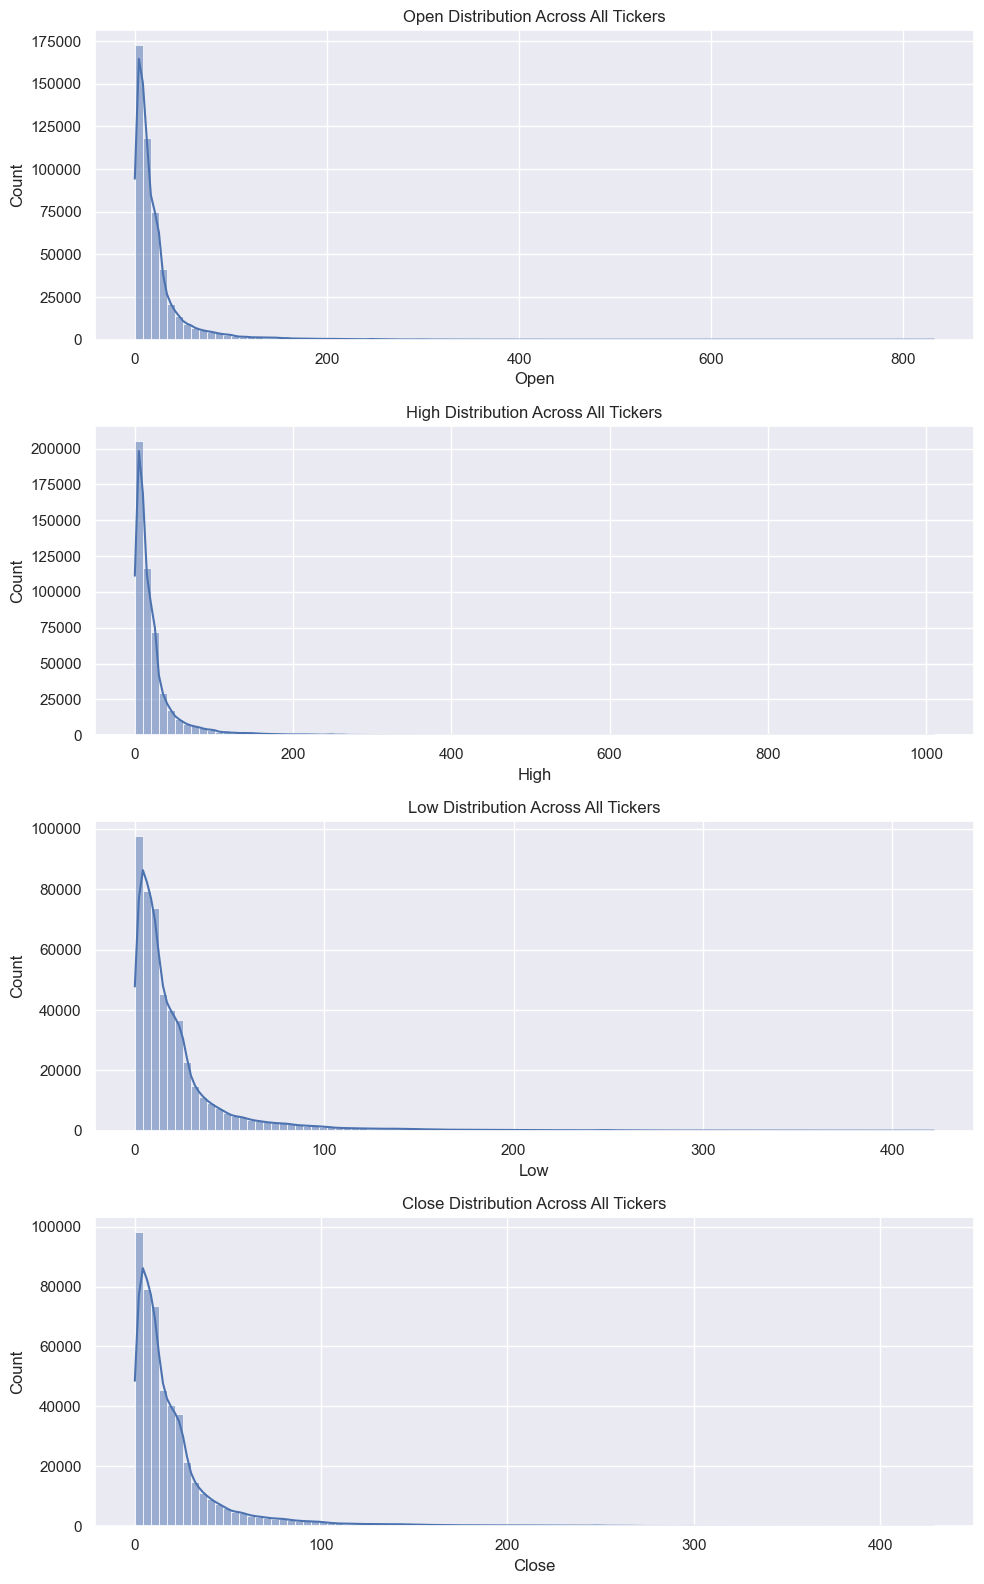

In [13]:


price_cols = ["Open", "High", "Low", "Close"]

fig, axes = plt.subplots(len(price_cols), 1, figsize=(10, 4*len(price_cols)))

for i, col in enumerate(price_cols):
    ax = axes[i]
    sns.histplot(
        data=eda_sample,
        x=col,
        bins=100,
        kde=True,
        ax=ax
    )
    ax.set_title(f"{col} Distribution Across All Tickers")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()


Continuous Variables Analysis

توزيع أسعار الأسهم برسمة واحدة

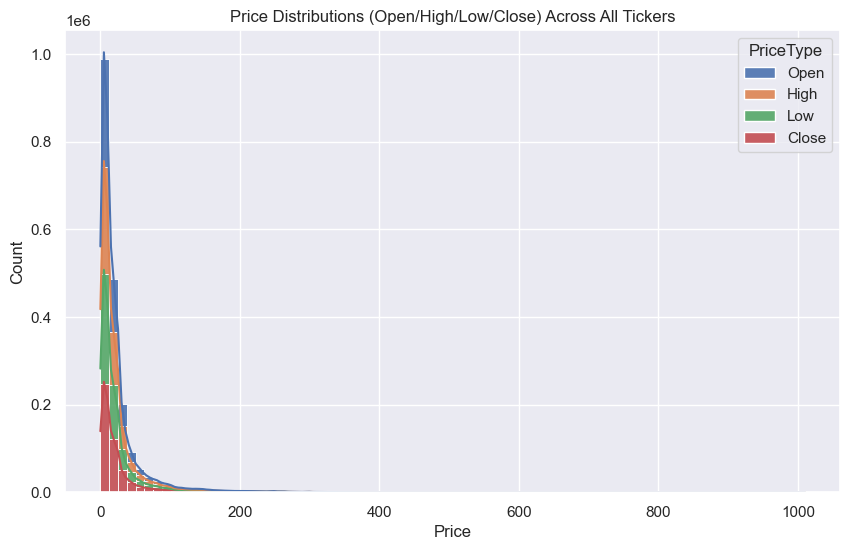

In [14]:

prices_long = eda_sample.melt(
    value_vars=price_cols,
    var_name="PriceType",
    value_name="Price"
)

plt.figure(figsize=(10, 6))
sns.histplot(
    data=prices_long,
    x="Price",
    hue="PriceType",
    bins=80,
    kde=True,
    multiple="stack",
    alpha=0.9,
)

plt.title("Price Distributions (Open/High/Low/Close) Across All Tickers")
plt.xlabel("Price")
plt.ylabel("Count")

plt.show()

